In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# Load datasets
train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test  = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

# Separate features & labels
X_train_raw = train.iloc[:, :-1].values
y_train_raw = train.iloc[:, -1].astype(int).values
X_test      = test.iloc[:, :-1].values
y_test      = test.iloc[:, -1].astype(int).values

# Manual class balancing (oversampling) 
rng = np.random.default_rng(42)
classes, counts = np.unique(y_train_raw, return_counts=True)
max_count = counts.max()

X_balanced, y_balanced = [], []
for c in classes:
    X_c = X_train_raw[y_train_raw == c]
    y_c = y_train_raw[y_train_raw == c]
    idx = rng.choice(len(X_c), size=max_count, replace=True)
    X_balanced.append(X_c[idx])
    y_balanced.append(y_c[idx])

X_balanced = np.vstack(X_balanced)
y_balanced = np.hstack(y_balanced)

# Train/Validation split
x_train, x_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Reshape & one-hot encode labels
x_train = x_train.reshape(-1, 187, 1)
x_val   = x_val.reshape(-1, 187, 1)
X_test  = X_test.reshape(-1, 187, 1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=5)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=5)

2026-01-17 17:13:32.620177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768670012.832686      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768670012.893734      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# CNN–LSTM Model
model = Sequential([
    Input(shape=(187, 1)),
    Conv1D(64, 6, activation='relu'), BatchNormalization(), MaxPool1D(3, 2, padding="same"),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPool1D(2, 2, padding="same"),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPool1D(2, 2, padding="same"),
    LSTM(64, return_sequences=True), LSTM(32),
    Flatten(),
    Dense(64, activation='relu'), Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=10, batch_size=32, callbacks=callbacks, verbose=1)

# Evaluation
print("Train Accuracy:", model.evaluate(x_train, y_train, verbose=0)[1])
print("Validation Accuracy:", model.evaluate(x_val, y_val, verbose=0)[1])
print("Test Accuracy:", model.evaluate(X_test, y_test, verbose=0)[1])


I0000 00:00:1768670048.956678      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1768670057.009432      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


9059/9059 ━━━━━━━━━━━━━━━━━━━━ 113s 12ms/step - accuracy: 0.8754 - loss: 0.3418 - val_accuracy: 0.9676 - val_loss: 0.0963
Epoch 2/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - accuracy: 0.9748 - loss: 0.0747 - val_accuracy: 0.9825 - val_loss: 0.0552
Epoch 3/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - accuracy: 0.9853 - loss: 0.0459 - val_accuracy: 0.9845 - val_loss: 0.0508
Epoch 4/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accuracy: 0.9890 - loss: 0.0338 - val_accuracy: 0.9914 - val_loss: 0.0261
Epoch 5/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - accuracy: 0.9919 - loss: 0.0258 - val_accuracy: 0.9907 - val_loss: 0.0286
Epoch 6/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - accuracy: 0.9934 - loss: 0.0214 - val_accuracy: 0.9965 - val_loss: 0.0129
Epoch 7/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accuracy: 0.9944 - loss: 0.0182 - val_accuracy: 0.9932 - val_loss: 0.0228
Epoch 8/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - accuracy: 0.9951 - lo

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
                  precision    recall  f1-score   support

          Normal       0.99      0.98      0.99     18118
Atrial Premature       0.70      0.88      0.78       556
             PVC       0.95      0.96      0.96      1448
      Fusion V-N       0.69      0.87      0.77       162
      Fusion P-N       0.98      0.99      0.98      1608

        accuracy                           0.98     21892
       macro avg       0.86      0.94      0.90     21892
    weighted avg       0.98      0.98      0.98     21892



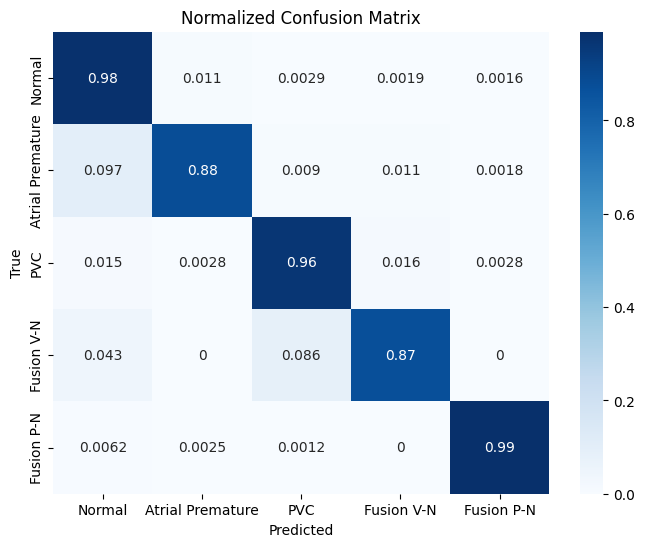

In [5]:
# Predictions
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=[
    'Normal', 'Atrial Premature', 'PVC', 'Fusion V-N', 'Fusion P-N'
]))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=[
    'Normal', 'Atrial Premature', 'PVC', 'Fusion V-N', 'Fusion P-N'
], yticklabels=[
    'Normal', 'Atrial Premature', 'PVC', 'Fusion V-N', 'Fusion P-N'
])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()